# Color Imaging

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import h, c, k

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1

In [2]:
CIE = pd.read_csv("Data/CIE_xyz_1964_10deg.csv", header = None)
CIE_data = pd.DataFrame.to_numpy(pd.DataFrame(CIE))

In [3]:
CIE_wavelengths = CIE_data[:,0]
x_bar, y_bar, z_bar = CIE_data[:,1], CIE_data[:,2], CIE_data[:,3]
z_bar = np.nan_to_num(z_bar)

In [4]:
# Desired wavelengths
visible_wavelengths = np.arange(380, 780 + 1, 10)
spectrum_wavelengths = np.linspace(400, 800, len(CIE_wavelengths))

## Tristimulus values

In [5]:
X, Y, Z, x, y, z = [], [], [], [], [], []

for wavelength in visible_wavelengths:
    
    # Calculate the Gaussian spectrum for specific wavelength
    amplitude, stdev = 1.0, 1.0
    light_spectrum = amplitude * np.exp(-((spectrum_wavelengths - wavelength)**2) / (2*stdev**2))
    
    # Locate the index of the target wavelength in the CMF data
    idx = np.argmin(np.abs(CIE_wavelengths - wavelength))
    
    # Calculate the tristimulus values for a specific wavelength
    X_val = np.trapz(x_bar[idx] * light_spectrum, spectrum_wavelengths)
    Y_val = np.trapz(y_bar[idx] * light_spectrum, spectrum_wavelengths)
    Z_val = np.trapz(z_bar[idx] * light_spectrum, spectrum_wavelengths)
    
    total_tristimulus = X_val + Y_val + Z_val
    x_val = X_val / total_tristimulus
    y_val = Y_val / total_tristimulus
    z_val = 1 - x_val - y_val
    
    X.append(X_val), Y.append(Y_val), Z.append(Z_val)
    x.append(x_val), y.append(y_val), z.append(z_val)

In [6]:
def xyz_chromaticity(wavelength, spectrum, standard_observer):
    trisim_XYZ = []
    for i in range(len(standard_observer)):
        integrand = spectrum * standard_observer[i]
        integral = np.trapz(integrand, wavelength)
        trisim_XYZ.append(integral)
    x, y, z = trisim_XYZ / np.sum(trisim_XYZ)
    return x, y

In [7]:
x_bound, y_bound = [], []

for wavelength in visible_wavelengths:
    dirac_delta_spec = np.zeros_like(CIE_wavelengths)
    dirac_delta_spec[np.where(CIE_wavelengths == wavelength)] = 1
    x, y = xyz_chromaticity(CIE_wavelengths, dirac_delta_spec, [x_bar, y_bar, z_bar])
    x_bound.append(x), y_bound.append(y)

## Planckian locus

In [8]:
def blackbody_radiation(wavelength, temperature):
    c1 = 2*np.pi*h*c*c
    c2 = h*c/k
    return c1/(wavelength**5) * 1/(np.exp(c2/wavelength/temperature) - 1)

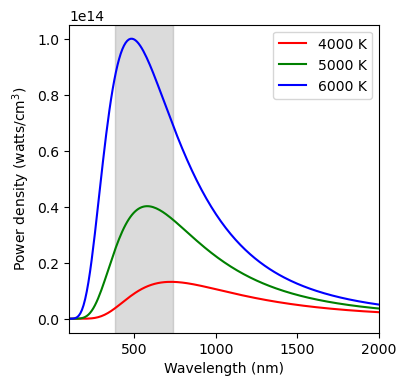

In [85]:
wavelength_vals = np.linspace(100, 10000, 1000)
temperature_vals = [4000, 5000, 6000]
colors = ["red", "green", "blue"]
spectrum_vals = []

for temp in temperature_vals:
    blackbody_spectrum = blackbody_radiation(wavelength_vals * 1e-9, temp)
    spectrum_vals.append(blackbody_spectrum)

fig, ax = plt.subplots()
    
for (i, temp), color in zip(enumerate(temperature_vals), colors):
    ax.plot(wavelength_vals, spectrum_vals[i], label = "{:.0f} K".format(temp), color = color)
    ax.axvspan(380, 740, alpha = 0.10, color = "gray")
    ax.set(xlabel = "Wavelength (nm)", ylabel = "Power density (watts/$\mathrm{cm}^3$)", xlim = (100, 2000))
    ax.legend()
    
plt.savefig("Results/blackbody radiation.png", dpi = 300)

In [9]:
# Desired temperatures
blackbody_temps = np.arange(1000, 10001, 1000)
x_locus, y_locus = [], []

for temp in blackbody_temps:
    blackbody_spectrum = blackbody_radiation(CIE_wavelengths * 1e-9, temp)
    x, y = xyz_chromaticity(CIE_wavelengths, blackbody_spectrum, [x_bar, y_bar, z_bar])
    x_locus.append(x), y_locus.append(y)

Text(0, 0.5, '$y$')

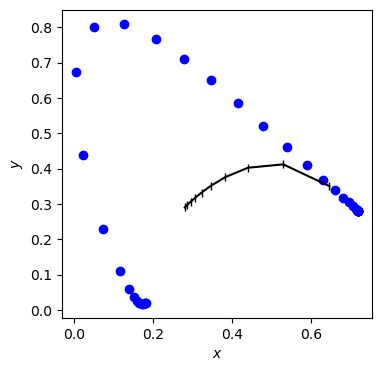

In [75]:
plt.scatter(x_bound, y_bound, color = "blue")
plt.plot(x_locus, y_locus, marker = "|", color = "black")
plt.xlabel("$x$")
plt.ylabel("$y$")